# Jupyter Notebooks Walkthrough

This notebook does a complete walkthrough of the kinds of things you can do on Jupyter notebooks. It starts at a similar place as that of "Lab 1 - Linux Application Development on Ultra96" but does so in a python context. We will explore how using python and Jupyter notebooks along with PYNQ overlays can accelerate embedded development on Xilinx devices.This walkthrough highlights the following steps:
1. Hello World! Compiling on Jupyter Notebooks
2. Debugging (PixieDebugger)
3. Profiling
4. OpenCV programming (filter2D + dilate) with profiling
5. Kernel acceleration using pre-built accelerators (aka overlay)
6. Overlay development with CMake and SDx

## 1. <font face="Courier" color=blue>Hello World!</font> Compiling on Jupyter Notebooks 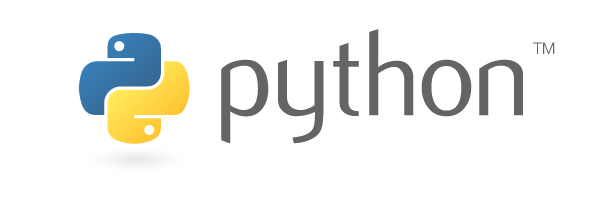

Compiling in Jupyter notebooks is as easy as selecting a box (cell) and clicking on the "Run" button on the toolbar. Python is an intepretive language so we "compile" and "run" in one step, on-the-fly. Markdown cells like this one are useful for adding text, images and HTML code. Code cells, like the one below, contain program code that can be run. Try running the cell below and note what happens if there is a syntax error.

In [ ]:
print("Hello World!")

Console messages and standard output is generated beneath the cell. Fix the above syntax error by adding a ')' and then run the cell again.

## 2. Debugging (PixieDebugger)
Even though each cell can contain just a single line of python code, oftentimes, a cell will contain several lines of code. In these cases, being able to run a debugger in Jupyter notebooks can be helpful to avoid adding lots of 'print' statements in your code. For this purpose, we'll be using the PixieDebugger add-on which provides a very familiar code debug environment. To initialize this, we simply ensure the PixieDust is installed by running "sudo -H pip3 install pixiedust" on our Ultra96. This is already done for this system so the next step is to import the library to our environment. 

**NOTE**: A error message about not being able to check for the latest version will occur if the Ultra96 does not have internet connection. This message can be safely ignored. The PixieDebugger github can be found [here](https://github.com/pixiedust/pixiedust)

In [ ]:
import pixiedust

## Revisit Lab1 - matrix multiply 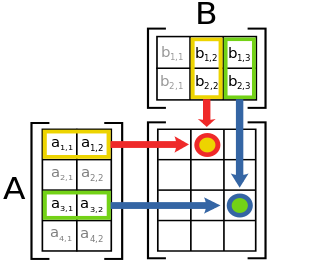
To illustrate debugging, we will revisit the matrix multiply design from Lab 1. First we will declare the sub-functions such as mmult_sw and matrix_multiply that was used in that lab. Note that these are equivalent functions to the C code used in Lab 1 but not exactly the same. Cells run in a notebook have variables and state that is maintained for the entire session, regardless of the order the cells are run.

In [ ]:
def mmult_sw(in1, in2, dim):
    out = [0]*(dim*dim)
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                out[i*dim +j] += in1[i*dim+k] * in2[k*dim+j]
    return out

import random
def matrix_multiply(dim):
    in1 = []
    in2 = []
    for index in range(dim*dim):
        in1.append(random.randint(0,dim))
        in2.append(random.randint(0,dim))
    sw_result = mmult_sw(in1,in2,dim)
    print("matrix multply")
    return sw_result

Next we will run the equivalent Lab 1 main() program. In this case, we will not allow our code to run forever but instead inject a bug in how the code is run. Looking at the code, we see that we call matrix_multiply in the inner loop and the main while loop should loop 10 times. Run the code below first and see how many matrix_multiply are called (hint: check the number of messages printed to the output).

In [ ]:
print("*********************************************************")
print("*   Linux Debug on Ultra96: Lab 1 - MMult Application   *")
print("*********************************************************")

max_loop_count = 10
led_loop_count = 0

while(led_loop_count < max_loop_count):
    for count in range(1):
        matrix_multiply(32)
    led_loop_count += 5

Now we enable the PixieDebugger by inserting the line "%%pixie_debuggger" in the first line (this needs to be in the first line). Run the cell below which has the line inserted. This time, you should be able to set a breakpoint in the matrix_multiply loop by clicking next to line 15 in the debugger window and enabling the red bug. Continue to run to the breakpoint by clicking on the leftmost arrow button in the debugger menu bar and observe what happens to the led_loop_count variable on each iteration (variable pane on right margin). 

On closer examination, you can see that line 15 should auto-incremented by 1 instead of 5 in order to count to 10. Make that change and run the cell again to verify the operation is now correct.

__NOTE__: If anything seems to get stuck, select menu "Kernel->Shutdown' and wait a few moments before selecting "Kernel->Restart" to restart the Jupyter notebook page again. Also note that the status of the cell with the debugger may not clear (stays at * ) but if the upper right circle next to "Python 3" is open and not filled in, then indicates the cell is idle.

In [ ]:
%%pixie_debugger

print("*********************************************************")
print("*   Linux Debug on Ultra96: Lab 1 - MMult Application   *")
print("*********************************************************")

max_loop_count = 10
led_loop_count = 0

while(led_loop_count < max_loop_count):
    for count in range(1):
        matrix_multiply(32)
    led_loop_count += 5

print("Done.")

## 3. Profiling
Understanding where the bottlenecks are in our code is very important. To enable profiling, we change first line from a debugger command to a profiling one. We enable profiling via the %%prun command which sorts based on 'cumulative' time, lists 10 functions and outputs the result to a file named 'prunSW'.

In [ ]:
%%prun -s cumulative -q -l 10 -T prun_mm

max_loop_count = 10
led_loop_count = 0

while(led_loop_count < max_loop_count):
    for count in range(1):
        matrix_multiply(32)
    led_loop_count += 1

We can then print the contents of that report (prunSW file). The profiler results list the processing tasks in order based on highest cumulative processing time as specified previously. You can also sort based on 'tottime' or 'percall'. For cumulative, the first two items on the report are generally the wrappers for the cell. After that, we see our functions matrix_multiply and the sub-function mmult_sw. We can now see how mmult_sw takes up the most processing time.

In [ ]:
print(open('prun_mm','r').read())

## 4. OpenCV programming (filter2D + dilate) with profiling 
The next step is to see how we transition from simple python code to vision processing code with OpenCV. We will first setup the USB camera and some helper functions before executing a few OpenCV functions. In this case, we read a frame from the camera and then perform a 2D filter and dilate function on the incoming image. The next two notebooks will explain this in more detail, but for now, we want to illustrate how coding with OpenCV and profiling can easily be done in Jupyter Notebooks.

## Setup and configure USB camera 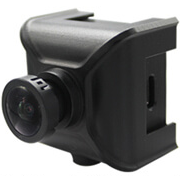
We use OpenCV (cv2) for capturing frames from a USB camera and processing those image frames. Here, we start by setting up the interface to the USB camera and configuring its resolution (1080p). A successful camera setup returns a 'True'. If something is is outputted, shutdown the notebook and restart it again.

In [ ]:
import cv2

camera = cv2.VideoCapture(0)

width = 1920
height = 1080
camera.set(cv2.CAP_PROP_FRAME_WIDTH,width)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT,height)

We add another helper function which sets up an IPython-based imshow call which encodes OpenCV image data to jpeg format before displaying it within the notebook itself. Other methods of displaying image data would perform similar conversions as well.

In [ ]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

## Read input frame from USB camera 
Read input frame and convert image to gray scale with OpenCV function cvtColor.

**NOTE**: We do a few extra reads up front to flush out the frame buffers in case camera was previously used

In [ ]:
# Flush webcam buffers (needed when rerunning notebook)
for _ in range(5):
    ret, frame_in = camera.read()

# Read in a frame
ret, frame_in = camera.read()
if ret:
    frame_in_gray = cv2.cvtColor(frame_in,cv2.COLOR_RGB2GRAY)
else:
    print("Error reading frame from camera.")
imshow(frame_in_gray)

## Run SW Filter2D + SW Dilate and measure performance 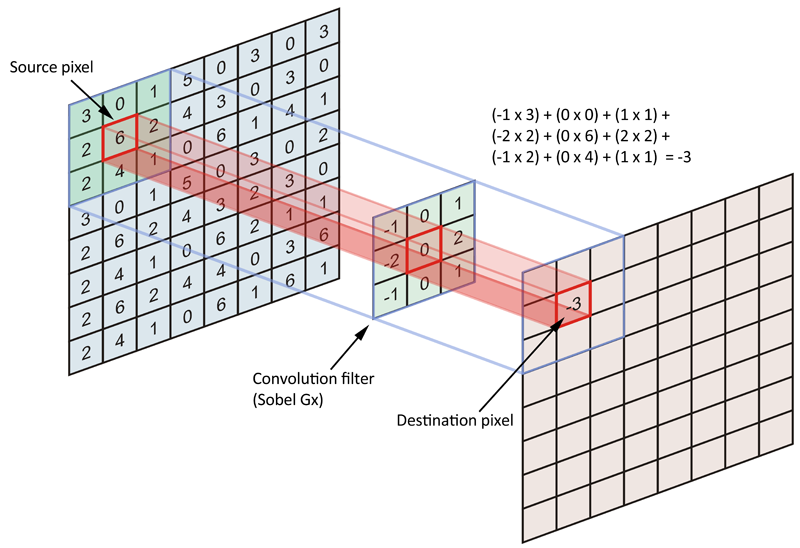
The OpenCV code below performs a 2D filter followed by a dilate function on live frames captured from the USB camera.
* [Filter2D OpenCV link](https://docs.opencv.org/3.2.0/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)
* [Dilate OpenCV link](https://docs.opencv.org/3.2.0/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c)

In [ ]:
%%prun -s cumulative -q -l 10 -T prunSW
import numpy as np
import time

#Sobel Hor filter  
kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
kernelD   = np.ones((3,3),np.uint8)
buf       = np.ones((height,width),np.uint8)
frame_out = np.ones((height,width),np.uint8)

num_frames    = 20

start = time.time()
for _ in range(num_frames):
    # Capture frame-by-frame
    ret, frame_in = camera.read()
    if (not ret):
        # Release the Video Device if ret is false
        camera.release()
        # Message to be displayed after releasing the device
        print("Released Video Resource")
        break
    frame_in_gray = cv2.cvtColor(frame_in,cv2.COLOR_RGB2GRAY)
    cv2.filter2D(frame_in_gray, -1, kernelF, buf, borderType=cv2.BORDER_CONSTANT)
    cv2.dilate(buf, kernelD, frame_out, borderType=cv2.BORDER_CONSTANT)
    imshow(frame_out)
    IPython.display.clear_output(wait=True)    
time_sw_total = time.time() - start
print("Frames per second:  " + str(num_frames / time_sw_total))

## Process SW profile results
As beore, we print out the profile results. We can actually parse this text file to obtain and store the actual per call processing time to be used later to visualize the performance. This parsing is done with the ! character and shell commands to cat/ grep/ awk can be used to obtain the percall time (stored as a list) and then convert it to type float.

In [ ]:
print(open('prunSW','r').read())
res = !cat prunSW | grep filter2D | awk '{{print $$2}}'
tottime_sw_filter2d = float(res[0])
res = !cat prunSW | grep dilate   | awk '{{print $$2}}'
tottime_sw_dilate   = float(res[0])

## 5. Kernel acceleration using pre-built accelerators (aka overlay)
The next step is to program an overlay on the Ultra96 and accelerate the expensive functions to improve peformance. 

## Program overlay

Here we program the overlay on the FPGA, load the associated overlay library and load the PYNQ xlnk memory manager library. More details to be found in later notebooks.

In [ ]:
import cv2 #NOTE: This needs to be loaded first

# Load filter2D + dilate overlay
from pynq import Overlay
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.bit")
bs.download()
import pynq_cv.overlays.xv2Filter2DDilate as xv2

# Load xlnk memory manager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.so')
mem_manager = Xlnk()

## Run HW Filter2D + HW Dilate and measure performance
Now we take advantage of the library of accelerators in our overlay and accelerate the same two OpenCV functions in FPGA fabric (HW). From a function signature point of view, it's about as simple as replacing the OpenCV library call (cv2) with a python-extended Xilinx OpenCV function call (xv2) provided to us by the overlay package. The other concept necessary for hardware acceleration is making sure we use continguous memory for our frames when required. This is done through the use of cma_array function as opposed to the numpy allocation functions. Some data copying will be necessary when moving data between numpy arrays and cma_arrays to be covered in future notebooks.

In [ ]:
%%prun -s tottime -q -l 10 -T prunHW
import numpy as np
import time

#Sobel Hor filter  
kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
kernelVoid = np.zeros(0)
xFin       = mem_manager.cma_array((height,width),np.uint8)
xFbuf      = mem_manager.cma_array((height,width),np.uint8)
xFout      = mem_manager.cma_array((height,width),np.uint8)

num_frames       = 20

xFin[:]    = frame_in_gray[:]

start = time.time()
for _ in range(num_frames):
    # Capture frame-by-frame
    ret, frame_in = camera.read()
    if (not ret):
        # Release the Video Device if ret is false
        camera.release()
        # Message to be displayed after releasing the device
        print("Released Video Resource")
        break
    frame_in_gray = cv2.cvtColor(frame_in,cv2.COLOR_RGB2GRAY)
    xFin[:]       = frame_in_gray[:]
    xv2.filter2D(xFin, -1, kernelF, xFbuf, borderType=cv2.BORDER_CONSTANT)
    xv2.dilate(xFbuf, kernelVoid, xFout, borderType=cv2.BORDER_CONSTANT)
    frame_out[:]  = xFout[:]
    imshow(frame_out)
    IPython.display.clear_output(wait=True)  
time_hw_total = time.time() - start
print("Frames per second:  " + str(num_frames / time_hw_total))

## Process HW profile results

In [ ]:
print(open('prunHW','r').read())
res = !cat prunHW | grep filter2D | awk '{{print $$2}}'
tottime_hw_filter2d = float(res[0])
res = !cat prunHW | grep dilate   | awk '{{print $$2}}'
tottime_hw_dilate   = float(res[0])

## Plot performance
In addition to having easy access to OpenCV functions, we can access functions from pyPlot for plotting results onto graphs and charts. Here, we take the recorded time data and plot out the processing times in a bar chart along with computed FPS for each function. Pay particular attention to the actual performance of each function and note the effect when placing two functions back-to-back in this example.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

TIME_SW   = [t*1000/num_frames for (t) in (time_sw_total, tottime_sw_dilate, tottime_sw_filter2d)]
FPS_SW    = [1000/t for (t) in (TIME_SW)]
TIME_HW   = [t*1000/num_frames for (t) in (time_hw_total, tottime_hw_dilate, tottime_hw_filter2d)]
FPS_HW    = [1000/t for (t) in (TIME_HW)]
LABELS    = ['Total','Dilate','Filter2D']

f, (ax1, ax2) = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(7,5))
x_pos = np.arange(len(LABELS))
plt.yticks(x_pos, LABELS)

ax1.barh(x_pos, FPS_SW, height=0.6, color='g', zorder=3)
ax1.set_xlabel("Frames per second")
ax1.set_ylabel("Kernel (SW)")
ax1.grid(zorder=0)

ax2.barh(x_pos, FPS_HW, height=0.6, color='b', zorder=3)
ax2.set_xlabel("Frames per second")
ax2.set_ylabel("Kernel (HW)")
ax2.grid(zorder=0)

plt.show()

## 6. Overlay development with CMake and SDx <img src=attachment:image.png width=150 align=right>
There are many ways to develop overlays for the PYNQ platform. One useful framework and the ones used in these OpenCV designs is through a CMake-based build flow targeting SDx platforms such as the Ultra96. More information on this can be found in the github repository [here](https://github.com/Xilinx/PYNQ-ComputerVision)
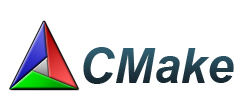

## Release USB camera resource

**NOTE**: This is needed to close the camera between subsequent runs. If the camera is unable to read a frame, be sure to call camera.release() and then try opening the VideoCapture again.

In [ ]:
camera.release()

<font color=red size=4>IMPORTANT NOTE</font>: Be sure to run the cell below, shutting down the notebook, before starting a new one. The notebook interface shows "No Kernel", the cell below will incorrectly show a running status [ * ]. You can ignore this an safely close the tab of the notebook. 

In [ ]:
%%javascript
Jupyter.notebook.session.delete();